Training model with sigmoid activation...


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model with tanh activation...
Training model with relu activation...


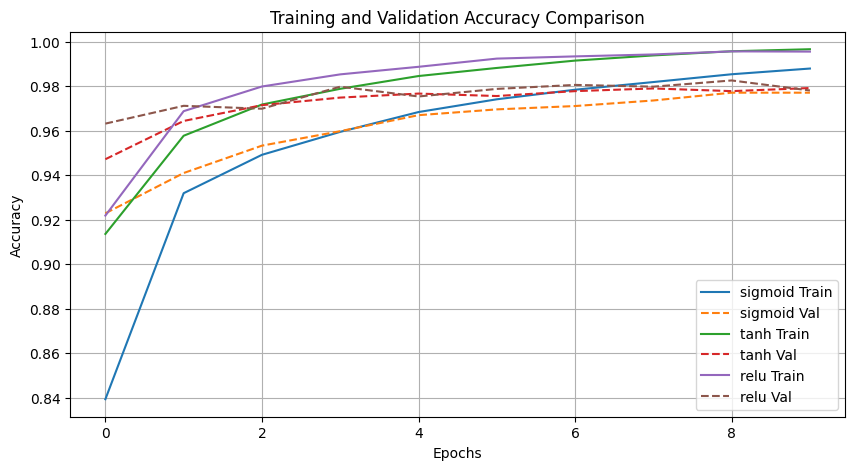

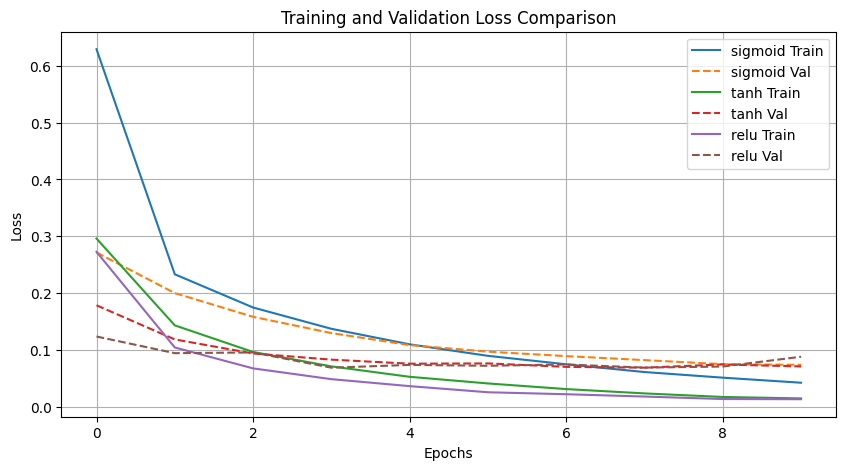

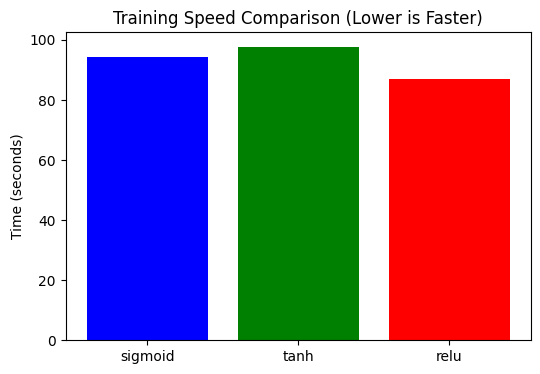

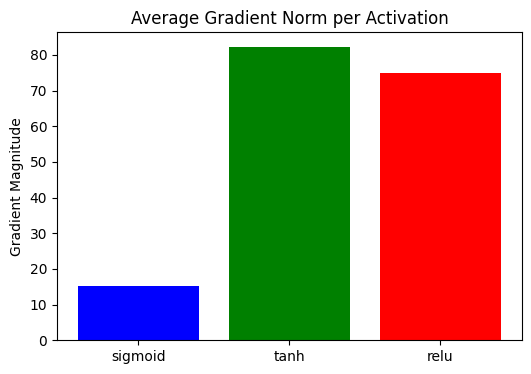

Sigmoid Test Accuracy: 0.9682
Tanh Test Accuracy: 0.9738
Relu Test Accuracy: 0.9772


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import time

# =========================
# Load & preprocess dataset
# =========================
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# =========================
# Function to create MLP model
# =========================
def create_mlp(activation):
    model = models.Sequential([
        layers.Dense(256, activation=activation, input_shape=(784,)),
        layers.Dense(128, activation=activation),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =========================
# Train models for each activation
# =========================
activations = ['sigmoid', 'tanh', 'relu']
histories = {}
train_times = {}

for act in activations:
    print(f"Training model with {act} activation...")
    model = create_mlp(act)
    start = time.time()
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                        epochs=10, batch_size=128, verbose=0)
    end = time.time()
    histories[act] = history
    train_times[act] = end - start

# =========================
# Gradient Flow Visualization
# =========================
# We'll inspect gradient norms to see how activations affect gradient magnitudes.

def compute_gradients(model, x_sample, y_sample):
    with tf.GradientTape() as tape:
        preds = model(x_sample, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_sample, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    grad_norms = [tf.norm(g) for g in grads if g is not None]
    return tf.reduce_mean(grad_norms).numpy()

x_sample = x_train[:256]
y_sample = y_train[:256]
grad_means = {}

for act in activations:
    model = create_mlp(act)
    model.fit(x_sample, y_sample, epochs=1, batch_size=64, verbose=0)
    grad_means[act] = compute_gradients(model, x_sample, y_sample)

# =========================
# Visualization
# =========================

def plot_metric(metric, title):
    plt.figure(figsize=(10, 5))
    for act in activations:
        plt.plot(histories[act].history[metric], label=f"{act} Train")
        plt.plot(histories[act].history[f'val_{metric}'], '--', label=f"{act} Val")
    plt.title(f"{title}")
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy and loss
plot_metric('accuracy', "Training and Validation Accuracy Comparison")
plot_metric('loss', "Training and Validation Loss Comparison")

# Plot training time
plt.figure(figsize=(6,4))
plt.bar(activations, [train_times[a] for a in activations], color=['blue','green','red'])
plt.title("Training Speed Comparison (Lower is Faster)")
plt.ylabel("Time (seconds)")
plt.show()

# Plot gradient magnitudes
plt.figure(figsize=(6,4))
plt.bar(grad_means.keys(), grad_means.values(), color=['blue','green','red'])
plt.title("Average Gradient Norm per Activation")
plt.ylabel("Gradient Magnitude")
plt.show()

# =========================
# Evaluate models
# =========================
for act in activations:
    model = create_mlp(act)
    model.fit(x_train, y_train, epochs=5, batch_size=128, verbose=0)
    test_acc = model.evaluate(x_test, y_test, verbose=0)[1]
    print(f"{act.capitalize()} Test Accuracy: {test_acc:.4f}")